The goal here is to simulate a realistic GPS signal, including transmitter and receiver clock errors, as well as signal propagation delay based on satellite and receiver positions. The code snippets below show how to set up the simulation parameters, retrieve satellite positions from SP3 data, and compute the necessary delays and clock errors.

We will not include relativistic effects or atmospheric delays in this simplified model.

In [1]:
import os
import pickle
import utils
from datetime import datetime, timedelta
import gnss_tools.orbits as orbits
import gnss_tools.time as time
import gnss_tools.coords as coords
import utils.signals.gps_l1ca as gps_l1ca_utils
import numpy as np
import matplotlib.pyplot as plt

SPEED_OF_LIGHT = 299792458.0  # m/s

In [2]:
# Create local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)

Simulate GNSS signal assuming synchronized clocks

In [3]:
# Define simulation time period
day_start_dt = datetime(2024, 5, 10)
day_end_dt = day_start_dt + timedelta(days=1)
day_start_gpst = time.convert_datetime_to_gps_seconds(day_start_dt)
day_end_gpst = time.convert_datetime_to_gps_seconds(day_end_dt)

# Define static RX position
rx_pos_geo = np.array((-118.57707656024262, 34.139012915514925, 361.0))  # lon, lat, alt in meters
rx_pos_ecf = coords.geo2ecf(rx_pos_geo)

# Download and parse SP3 orbit data
sp3_arrays = orbits.download_and_parse_sp3_data(day_start_gpst, day_end_gpst, data_dir, True)

sat_positions_ecf = {}
sat_positions_sky = {}
propagation_delays = {}
geom_sim_start_gpst = day_start_gpst
geom_sim_duration = day_end_gpst - day_start_gpst
geom_sim_epochs = np.arange(0.0, geom_sim_duration, 1.0)  # every 1 seconds
for sat_id in sp3_arrays.position.keys():
    sat_pos_ecf = sp3_arrays.position[sat_id]
    sp3_epochs = sp3_arrays.epochs
    lagrange_order = 7
    sat_positions_ecf[sat_id] = orbits.compute_array_lagrange_interpolation(
        geom_sim_epochs, sp3_epochs - geom_sim_start_gpst, sat_pos_ecf, lagrange_order
    )
    sat_positions_sky[sat_id] = coords.ecf2sky(rx_pos_ecf, sat_positions_ecf[sat_id])
    geometric_range = np.linalg.norm(sat_positions_ecf[sat_id] - rx_pos_ecf, axis=1)
    propagation_delays[sat_id] = geometric_range / SPEED_OF_LIGHT

In [4]:
# Recompute propagation delays to account for Earth rotation during signal travel time
corrected_propagation_delays = {}
for sat_id in sat_positions_ecf.keys():
    sat_pos_ecf = sat_positions_ecf[sat_id]
    prop_delay = propagation_delays[sat_id]
    sat_pos_rotated = coords.rotate_pos_ecf(sat_pos_ecf, -prop_delay)
    geometric_range = np.linalg.norm(sat_pos_rotated - rx_pos_ecf, axis=1)
    corrected_propagation_delays[sat_id] = geometric_range / SPEED_OF_LIGHT

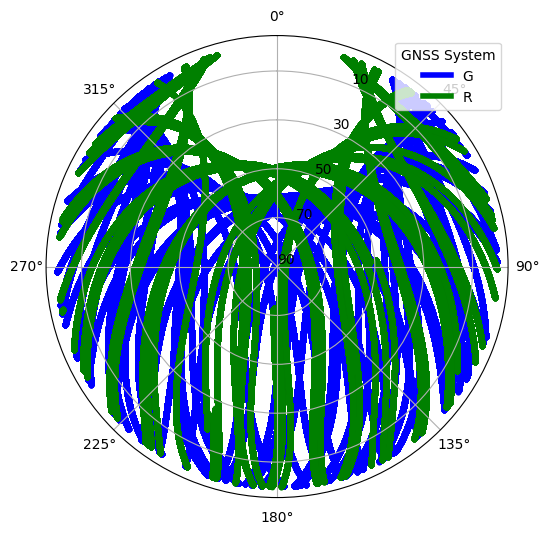

In [5]:
# Make sky plot of all satellites

# Check for elevation > 0 deg
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="polar")
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
gnss_colors = {
    "G": "blue",
    "R": "green",
    # "C": "red",
    # "E": "orange",
}
for sat_id, sat_pos_sky in sat_positions_sky.items():
    elevation = sat_pos_sky[:, 1]
    azimuth = sat_pos_sky[:, 0]
    mask = elevation > 0.0
    svid_sys = sat_id[0]
    if svid_sys not in gnss_colors:
        continue
    color = gnss_colors[svid_sys]
    ax.scatter(
        np.radians(azimuth[mask]),
        90.0 - elevation[mask],
        color=color,
        s=10,
    )
rticks = [0, 20, 40, 60, 80]
ax.set_yticks(rticks)
ax.set_yticklabels([str(90 - rtick) for rtick in rticks])
labels = list(gnss_colors.keys())
handles = [plt.Line2D([0], [0], lw=4, color=gnss_colors[label]) for label in labels]
ax.legend(handles, labels, loc="upper right", title="GNSS System")
plt.show()

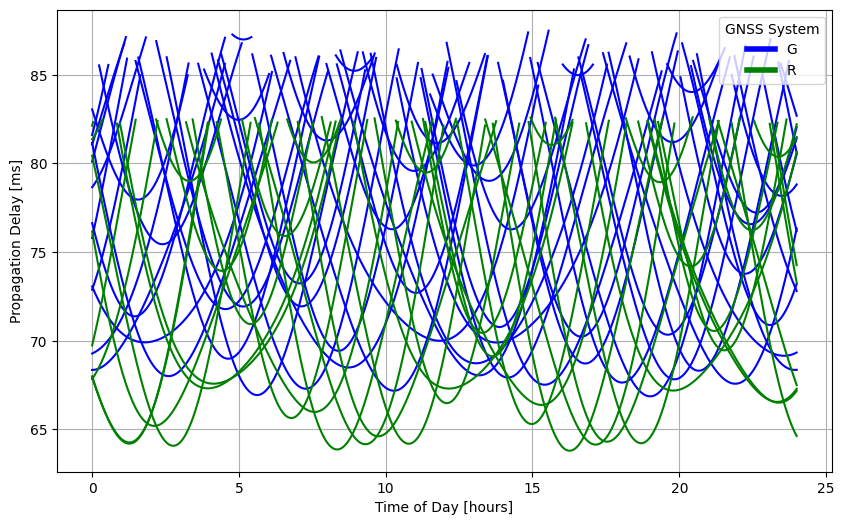

In [6]:
# Plot propagation delays for each satellite (when elevation > 0 deg)
fig, ax = plt.subplots(figsize=(10, 6))
plot_times = (geom_sim_epochs) / 3600.0  # in hours
nan_mask = np.nan * np.ones_like(plot_times)
for sat_id in sat_positions_ecf.keys():
    if sat_id[0] not in gnss_colors:
        continue
    sat_pos_sky = sat_positions_sky[sat_id]
    elevation = sat_pos_sky[:, 1]
    nan_mask[:] = np.nan
    nan_mask[elevation > 0.0] = 1.0
    ax.plot(
        plot_times,
        corrected_propagation_delays[sat_id] * 1e3 * nan_mask,
        color = gnss_colors[sat_id[0]],
    )
labels = list(gnss_colors.keys())
handles = [plt.Line2D([0], [0], lw=4, color=gnss_colors[label]) for label in labels]
ax.legend(handles, labels, loc="upper right", title="GNSS System")
ax.set_xlabel("Time of Day [hours]")
ax.set_ylabel("Propagation Delay [ms]")
ax.grid()

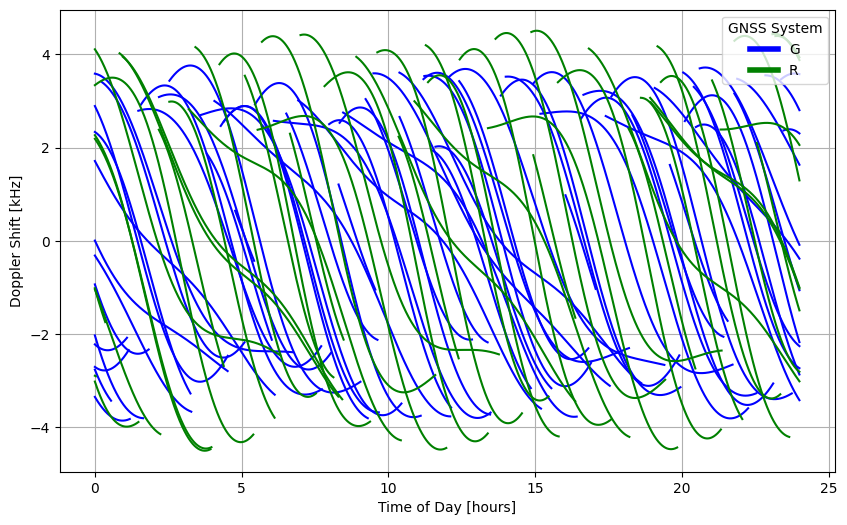

In [7]:
# Plot Doppler frequencies corresponding to L1 center frequency
fig, ax = plt.subplots(figsize=(10, 6))
l1_center_freq = 1575.42e6  # Hz

plot_times = (geom_sim_epochs) / 3600.0  # in hours
nan_mask = np.nan * np.ones_like(plot_times)
for sat_id in sat_positions_ecf.keys():
    if sat_id[0] not in gnss_colors:
        continue
    prop_delay = corrected_propagation_delays[sat_id]
    prop_delay_deriv = np.gradient(prop_delay, geom_sim_epochs)
    los_velocity = -prop_delay_deriv * SPEED_OF_LIGHT
    doppler_shift = l1_center_freq * (los_velocity / SPEED_OF_LIGHT)
    
    sat_pos_sky = sat_positions_sky[sat_id]
    elevation = sat_pos_sky[:, 1]
    nan_mask[:] = np.nan
    nan_mask[elevation > 0.0] = 1.0
    
    ax.plot(
        plot_times,
        doppler_shift / 1e3 * nan_mask,  # in kHz
        color = gnss_colors[sat_id[0]],
    )
labels = list(gnss_colors.keys())
handles = [plt.Line2D([0], [0], lw=4, color=gnss_colors[label]) for label in labels]
ax.legend(handles, labels, loc="upper right", title="GNSS System")
ax.set_xlabel("Time of Day [hours]")
ax.set_ylabel("Doppler Shift [kHz]")
ax.grid()

In [9]:
# Choose 2-second window in middle of day for further analysis
sim_duration = 2.0  # seconds
sim_start_gpst = day_start_gpst + 12 * 3600 - 15  # 12:00:00 GPST minus 15 seconds
sim_end_gpst = sim_start_gpst + sim_duration

samp_rate = 2e6  # 2 MHz
sim_time_arr = np.arange(0, sim_duration, 1.0 / samp_rate)
sim_num_samples = len(sim_time_arr)

# First, compute the noise power based on receiver equivalent noise temperature and front-end bandwidth
k_boltzmann = 1.380649e-23  # J/K
rx_sys_temp_k = 535.0  # Kelvin
front_end_bw_hz = samp_rate  # Hz
noise_power_watts = k_boltzmann * rx_sys_temp_k * front_end_bw_hz

noise_samples = np.sqrt(noise_power_watts) * (
    np.random.randn(sim_num_samples) + 1j * np.random.randn(sim_num_samples)
) / np.sqrt(2)

# Assume zero clock error for receiver/satellite
# Interpolate propagation delay to simulate code phase and carrier phase at each sample time

# Let's set satellite C/N0 based on elevation angle
# C/N0 (dB-Hz) is measured using signal power at baseband after front-end filtering/sampling
def map_elev_to_cn0(elev_deg):
    """Simple mapping from elevation angle (degrees) to C/N0 (dB-Hz)"""
    if elev_deg < 0.0:
        return 0.0
    elif elev_deg >= 75.0:
        return 55.0
    else:
        return 25.0 + (30.0 * elev_deg / 75.0)

noise_free_signal_samples = np.zeros(sim_num_samples, dtype=complex)

sat_params = {}

for sat_id in sat_positions_ecf.keys():
    const_letter, prn = sat_id[0], int(sat_id[1:])
    if const_letter not in ["G"]:
        continue
    # check which GPS satellite elevations are greater than 5 degrees
    sat_pos_sky = sat_positions_sky[sat_id]
    _i0 = np.searchsorted(geom_sim_epochs, sim_start_gpst - geom_sim_start_gpst)
    sat_elev = sat_pos_sky[_i0, 1]
    if sat_elev < 5.0:
        continue

    sat_cn0_dBHz = map_elev_to_cn0(sat_elev)
    signal_power = noise_power_watts / front_end_bw_hz * 10**(sat_cn0_dBHz / 10)
    signal_amp = np.sqrt(signal_power)

    prop_delay_interp = np.interp(
        sim_time_arr, geom_sim_epochs + (geom_sim_start_gpst - sim_start_gpst),
        corrected_propagation_delays[sat_id]
    )

    code_seq = 1 - 2 * gps_l1ca_utils.generate_code_sequence_L1CA(prn).astype(np.int8)
    code_phase_chips = (sim_time_arr - prop_delay_interp) * gps_l1ca_utils.CODE_RATE
    code_chip_indices = (code_phase_chips).astype(int) % gps_l1ca_utils.CODE_LENGTH
    code_samples = code_seq[code_chip_indices]

    num_data_bits = int(np.ceil(sim_duration * gps_l1ca_utils.DATA_SYMBOL_RATE))
    data_bits = np.random.choice([-1, 1], size=num_data_bits)
    data_bit_indices = ((sim_time_arr - prop_delay_interp) * gps_l1ca_utils.DATA_SYMBOL_RATE).astype(int) % num_data_bits
    data_samples = data_bits[data_bit_indices]

    carrier_phase = -2.0 * np.pi * gps_l1ca_utils.CARRIER_FREQ * prop_delay_interp
    carrier_samples = np.exp(1j * carrier_phase)

    signal_samples = signal_amp * code_samples * data_samples * carrier_samples
    noise_free_signal_samples += signal_samples

    sat_params[sat_id] = {
        "elevation_deg": sat_elev,
        "cn0_dBHz": sat_cn0_dBHz,
        "signal_power_watts": signal_power,
        "signal_amplitude": signal_amp,
        "initial_code_phase_chips": code_phase_chips[0],
        "initial_carrier_phase_rad": carrier_phase[0],
        "data_bits": data_bits.copy(),
        "initial_doppler_hz": -(gps_l1ca_utils.CARRIER_FREQ * np.gradient(prop_delay_interp[:10], sim_time_arr[:10]))[0],
    }
    
    print(f"Sat {sat_id}: Elev {sat_elev:.1f} deg, C/N0 {sat_cn0_dBHz:.1f} dB-Hz, Signal Power {signal_power:.3e} W, Amp {signal_amp:.3e}")

Sat G02: Elev 5.7 deg, C/N0 27.3 dB-Hz, Signal Power 3.938e-18 W, Amp 1.984e-09
Sat G05: Elev 12.7 deg, C/N0 30.1 dB-Hz, Signal Power 7.507e-18 W, Amp 2.740e-09
Sat G07: Elev 62.3 deg, C/N0 49.9 dB-Hz, Signal Power 7.276e-16 W, Amp 2.697e-08
Sat G08: Elev 30.7 deg, C/N0 37.3 dB-Hz, Signal Power 3.951e-17 W, Amp 6.286e-09
Sat G09: Elev 38.3 deg, C/N0 40.3 dB-Hz, Signal Power 7.948e-17 W, Amp 8.915e-09
Sat G13: Elev 17.8 deg, C/N0 32.1 dB-Hz, Signal Power 1.203e-17 W, Amp 3.468e-09
Sat G14: Elev 57.5 deg, C/N0 48.0 dB-Hz, Signal Power 4.648e-16 W, Amp 2.156e-08
Sat G17: Elev 19.7 deg, C/N0 32.9 dB-Hz, Signal Power 1.430e-17 W, Amp 3.782e-09
Sat G20: Elev 11.0 deg, C/N0 29.4 dB-Hz, Signal Power 6.455e-18 W, Amp 2.541e-09
Sat G21: Elev 6.3 deg, C/N0 27.5 dB-Hz, Signal Power 4.181e-18 W, Amp 2.045e-09
Sat G22: Elev 37.4 deg, C/N0 39.9 dB-Hz, Signal Power 7.287e-17 W, Amp 8.536e-09
Sat G30: Elev 60.1 deg, C/N0 49.1 dB-Hz, Signal Power 5.948e-16 W, Amp 2.439e-08


In [10]:
noise_samples_var = np.var(noise_samples)
signals_samples_var = np.var(noise_free_signal_samples)
print(f"Signal Samples Variance: {signals_samples_var:.3e}, Noise Samples Variance: {noise_samples_var:.3e}")
# Note that signal variance is sufficiently smaller than noise variance that we can roughly assume that
# C/N0 degradation due to cross-signal interference is negligible at this bandwidth.

baseband_samples = noise_free_signal_samples + noise_samples

num_quant_bits = 4
num_quant_levels = 2**num_quant_bits
# assume even quantization levels between +/- max_signal_amp
max_signal_amp = np.max(np.abs(baseband_samples))
quantized_samples_real = np.floor(baseband_samples.real / max_signal_amp * (num_quant_levels / 2 - 1) + 0.5)
quantized_samples_imag = np.floor(baseband_samples.imag / max_signal_amp * (num_quant_levels / 2 - 1) + 0.5)
quantized_samples = quantized_samples_real + 1j * quantized_samples_imag

Signal Samples Variance: 2.028e-15, Noise Samples Variance: 1.477e-14


In [11]:
# Save the samples to a file to use for acquisition and tracking testing
samples_output_filepath = os.path.join(data_dir, "simulated_gps_l1ca_signal_samples.npy")
np.save(samples_output_filepath, quantized_samples)

params_output_filepath = os.path.join(data_dir, "simulated_gps_l1ca_signal_params.npy")
params = {
    "samp_rate": samp_rate,
    "sat_params": sat_params,
}
with open(params_output_filepath, "wb") as f:
    pickle.dump(params, f)